In [208]:
#https://www.kaggle.com/code/rehabahmedkhalifa/credit-classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import linregress




In [209]:
# Import raw data
df=pd.read_csv("credit_train.csv" ,sep="," ,encoding="utf-8")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

In [210]:
# Drop any rows that have blank values in the Credit Score or Annual Income columns
df = df.dropna(subset=['Credit Score', 'Annual Income'])

# Replace any blanks with zeros in the following columns
df['Months since last delinquent']=df['Months since last delinquent'].fillna(0)
df['Bankruptcies']=df['Bankruptcies'].fillna(0)
df['Tax Liens']=df['Tax Liens'].fillna(0)

# As the 'Loan ID' column should be unique, remove any rows with a duplicated loan ID
df = df.drop_duplicates(subset=['Loan ID'])

df['Credit Score'].value_counts().sort_index()

Credit Score
585.0      9
586.0      6
587.0      8
588.0     13
589.0      5
          ..
7470.0    51
7480.0    43
7490.0    23
7500.0    24
7510.0     9
Name: count, Length: 324, dtype: int64

In [211]:
# Value Counts of the Credit Score column shows some 4 digit credit scores where an extra 0 has been added to the end
# To remove the 4th digit of the credit score if present
df['Credit Score'] = df['Credit Score'].astype(int).apply(lambda x: x/10 if len(str(x)) == 4 else x)

# Convert the Credit Score column to int
df['Credit Score'] = df['Credit Score'].astype(float).astype(int)

# Ensure all credit scores are valid credit score values
df['Credit Score'].value_counts().sort_index()

Credit Score
585      11
586       7
587       8
588      13
589       6
       ... 
747    1876
748    1641
749     850
750    1258
751     732
Name: count, Length: 167, dtype: int64

In [212]:
# Create a Debt to Income Ratio column
df["Monthly Debt"] = df["Monthly Debt"].astype(int)
df["Annual Income"] = df["Annual Income"].astype(int)

df["Debt to Income Ratio"] = df["Monthly Debt"]/(df["Annual Income"]/12).astype(float)
df["Debt to Income Ratio"] = df["Debt to Income Ratio"].round(4)

# Create a 0 or 1 column for Fully Paid vs Charged Off
df['Status Value'] = df['Loan Status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
df["Status Value"] = df["Status Value"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67052 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       67052 non-null  object 
 1   Customer ID                   67052 non-null  object 
 2   Loan Status                   67052 non-null  object 
 3   Current Loan Amount           67052 non-null  float64
 4   Term                          67052 non-null  object 
 5   Credit Score                  67052 non-null  int32  
 6   Annual Income                 67052 non-null  int32  
 7   Years in current job          64196 non-null  object 
 8   Home Ownership                67052 non-null  object 
 9   Purpose                       67052 non-null  object 
 10  Monthly Debt                  67052 non-null  int32  
 11  Years of Credit History       67052 non-null  float64
 12  Months since last delinquent  67052 non-null  float64
 13  Number

In [213]:
# Exclude outliers from Annual Income
quartiles = df['Annual Income'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

df = df.loc[(df['Annual Income'] > lower_bound) & (df['Annual Income'] < upper_bound)]
df.info()

# As you can see below, excluding the outliers eliminated 3,136 rows

<class 'pandas.core.frame.DataFrame'>
Index: 63916 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       63916 non-null  object 
 1   Customer ID                   63916 non-null  object 
 2   Loan Status                   63916 non-null  object 
 3   Current Loan Amount           63916 non-null  float64
 4   Term                          63916 non-null  object 
 5   Credit Score                  63916 non-null  int32  
 6   Annual Income                 63916 non-null  int32  
 7   Years in current job          61082 non-null  object 
 8   Home Ownership                63916 non-null  object 
 9   Purpose                       63916 non-null  object 
 10  Monthly Debt                  63916 non-null  int32  
 11  Years of Credit History       63916 non-null  float64
 12  Months since last delinquent  63916 non-null  float64
 13  Number

In [214]:
# Identify the values in the Purpose column
df['Purpose'].value_counts()

Purpose
Debt Consolidation      50673
other                    3749
Home Improvements        3548
Other                    2056
Business Loan             910
Buy a Car                 849
Medical Bills             680
Buy House                 408
Take a Trip               350
major_purchase            231
small_business            177
moving                     89
wedding                    68
Educational Expenses       66
vacation                   57
renewable_energy            5
Name: count, dtype: int64

In [215]:
# Clean up the Purpose colmun and consolidate similar categories
df['Purpose'].replace({'small_business': 'Business Loan'}, inplace=True)
df['Purpose'].replace({'Buy a Car': 'Car Loan'}, inplace=True)
df['Purpose'].replace({'Buy House': 'Mortgage'}, inplace=True)
df['Purpose'].replace(['other','major_purchase','Educational Expenses',"moving",'renewable_energy','wedding'],'Other', inplace=True)
df['Purpose'].replace(['Take a Trip','vacation'],'Vacation', inplace=True)


df['Purpose'].value_counts()

# As you can see below, we reduced the number of Purpose categories from 16 to 8

Purpose
Debt Consolidation    50673
Other                  6264
Home Improvements      3548
Business Loan          1087
Car Loan                849
Medical Bills           680
Mortgage                408
Vacation                407
Name: count, dtype: int64

In [216]:
# Create the bins in which Credit Scores will be grouped 
bins = [0, 579, 669, 739, 799, 850]

# Create the names for the five bins
group_names = ["Poor", "Fair", "Good", "Very Good", "Excellent"]

# Slice the data and place it into bins
df["Credit Score Rating"] = pd.cut(df["Credit Score"], 
                                              bins, labels=group_names, 
                                              include_lowest=True)
df["Credit Score Rating"].value_counts()

Credit Score Rating
Good         42316
Very Good    17397
Fair          4203
Poor             0
Excellent        0
Name: count, dtype: int64

In [217]:
# To vetter visualize what makes sense for our Debt-to-Income Ratio buckets
df["Debt to Income Ratio"].describe()

count    63916.000000
mean         0.174044
std          0.079637
min          0.000000
25%          0.115000
50%          0.171000
75%          0.229500
max          0.400000
Name: Debt to Income Ratio, dtype: float64

In [218]:
# Create the bins in which Annual Income will be grouped 
bins = [0,.09999, .19999, .29999, .4]

# Create the names for the bins
group_names = ['Under 10%', '10%-20%', '20%-30%', '30%-40%']

# Slice the data and place it into bins
df["Debt-To-Income Bucket"] = pd.cut(df["Debt to Income Ratio"], 
                                              bins, labels=group_names, 
                                              include_lowest=True)
df["Debt-To-Income Bucket"].value_counts()

Debt-To-Income Bucket
10%-20%      27950
20%-30%      19313
Under 10%    12320
30%-40%       4333
Name: count, dtype: int64

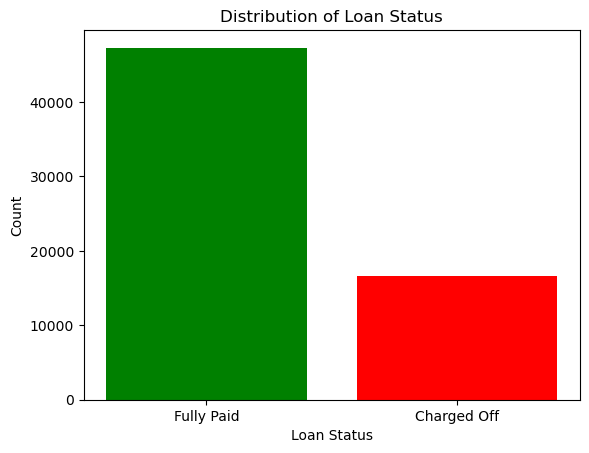

In [219]:
# Create a bar chart of the number of loans Fully Paid vs Charged Off
status_counts = df['Loan Status'].value_counts()
plt.bar(status_counts.index, status_counts.values, color=['green', 'red'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Loan Status')
plt.show()

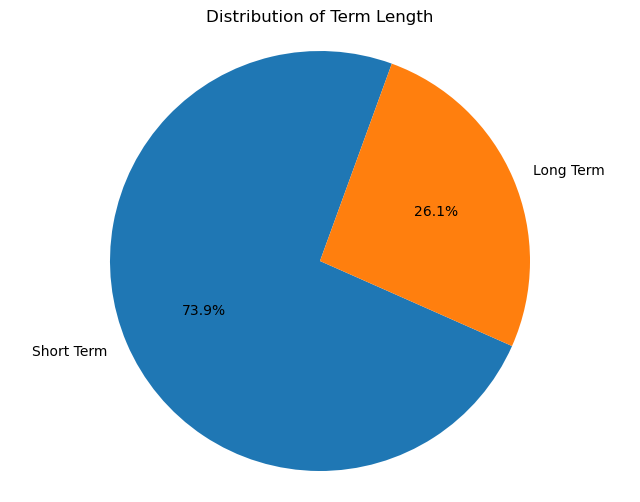

In [220]:
# Create a pie chart showing the breakdown of Short Term vs Long Term loans
term_counts = df['Term'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.pie(term_counts, labels=term_counts.index, autopct='%1.1f%%', startangle=70)

# Adding title
plt.title('Distribution of Term Length')

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<Figure size 1600x1000 with 0 Axes>

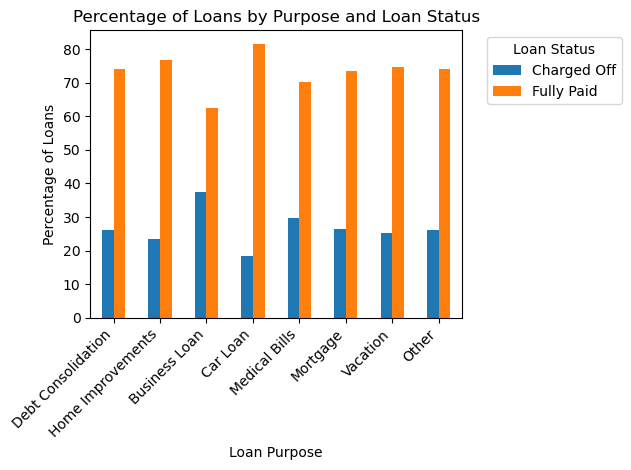

In [221]:
# Grouping the data by 'Purpose' and 'Loan Status' and counting the occurrences
grouped = df.groupby(['Purpose', 'Loan Status']).size().unstack(fill_value=0)

# Ordering the 'Purpose' column based on specified order
order = ['Debt Consolidation', 'Home Improvements', 'Business Loan', 'Car Loan', 'Medical Bills', 'Mortgage', 'Vacation', 'Other']
grouped = grouped.reindex(order)

# Calculating the total count of loans for each purpose
total_loans_by_purpose = grouped.sum(axis=1)

# Calculating the percentage of loans for each loan status within each purpose
percentage_grouped = grouped.divide(total_loans_by_purpose, axis=0) * 100

# Plotting the clustered bar graph with a larger figure size
plt.figure(figsize=(16, 10))
percentage_grouped.plot(kind='bar', stacked=False)

# Adding labels and title
plt.title('Percentage of Loans by Purpose and Loan Status')
plt.xlabel('Loan Purpose')
plt.ylabel('Percentage of Loans')
plt.xticks(rotation=45, ha='right')

# Displaying the plot with a separate legend outside the plot area
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# The Clusterer Bar Graph below shows that Business Loans have the highest likelihood of being charged off while Car Loans have the lowest likelihood

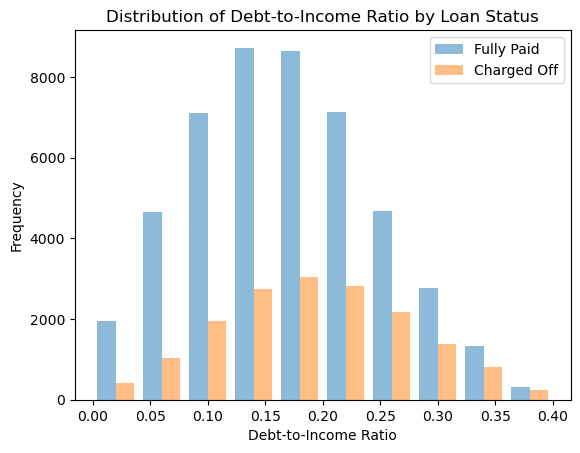

In [222]:
#Plot a histogrm of Debt to Income Ratio by Loan Status
grouped_data = df.groupby('Loan Status')['Debt to Income Ratio']

# Create a histogram for each group
plt.hist([grouped_data.get_group(status) for status in df['Loan Status'].unique()],
         bins=10, alpha=0.5, label=df['Loan Status'].unique())

# Adding labels and title
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Debt-to-Income Ratio by Loan Status')

# Adding legend
plt.legend()

# Show the plot
plt.show()

# What the below Histogram Chart shows is that as the Debt-to-Income ratio increases, the chances of the loan being charged off increases.
# As seen inbetween the 0.35 - 0.40 bucket, the chances of the loan being Paid Off vs Charged Off is almost 50/50

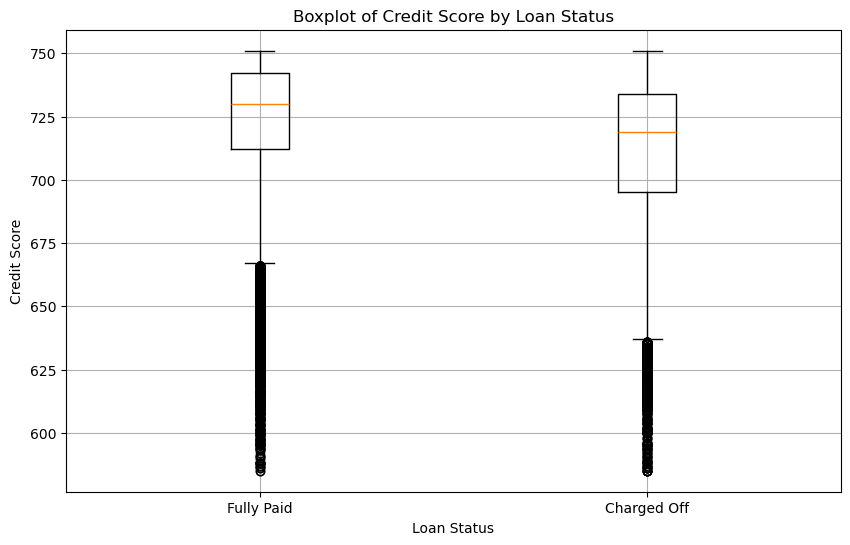

In [223]:
# Create a Boxplot of Credit Score by Loan Status
# Filter data by loan status
charged_off_data = df[df['Loan Status'] == 'Charged Off']
paid_off_data = df[df['Loan Status'] == 'Fully Paid']

# Create the Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([paid_off_data['Credit Score'],charged_off_data['Credit Score']], labels=['Fully Paid','Charged Off'])
plt.title('Boxplot of Credit Score by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Credit Score')
plt.grid(True)
plt.show()

# Boxplot below shows that the Fully Paid loans typically have a higher Credit Score vs Charged Off

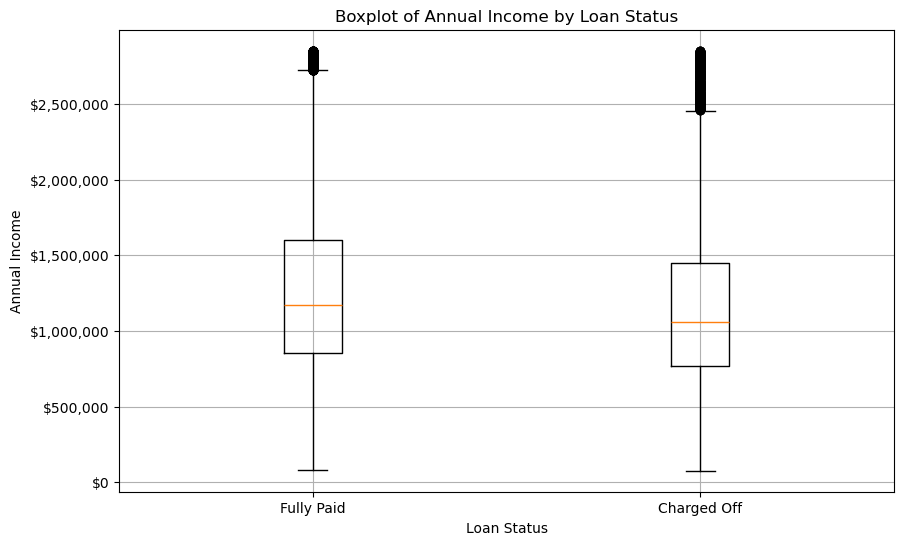

In [224]:
# Create a Boxplot of Annual Income by Loan Status
# Create the Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([paid_off_data['Annual Income'],charged_off_data['Annual Income']], labels=['Fully Paid','Charged Off'])
plt.title('Boxplot of Annual Income by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')

# Formatting y-axis tickmarks as USD
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

# Boxplot below shows that people with a higher Annual Income are more likely to pay off their loans

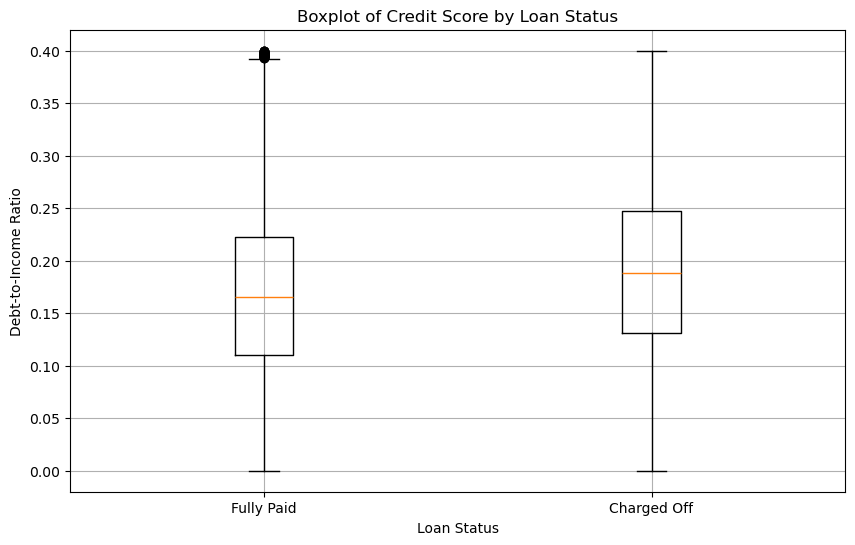

In [225]:
# Create a Boxplot of Debt-to-Income Ratio by Loan Status

# Create the Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([paid_off_data['Debt to Income Ratio'],charged_off_data['Debt to Income Ratio']], labels=['Fully Paid','Charged Off'])
plt.title('Boxplot of Credit Score by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Debt-to-Income Ratio')
plt.grid(True)
plt.show()

# Boxplot below shows that the individuals with a higher Debt to Income ratio are more likely to charge off their loans

In [226]:
# Create a dataframe of the Credit Score metrics between Fully Paid vs Charged 
df_data = pd.DataFrame({'Credit Scores (Paid Off)': paid_off_data['Credit Score'].describe(),
                    'Credit Scores (Charged Off)': charged_off_data['Credit Score'].describe(),
                    'Annual Income (Paid Off)': paid_off_data['Annual Income'].describe(),
                    'Annual Income (Charged Off)': charged_off_data['Annual Income'].describe()})

df_data[['Credit Scores (Paid Off)','Credit Scores (Charged Off)']] = df_data[['Credit Scores (Paid Off)','Credit Scores (Charged Off)']].astype(float).round(0).astype(int)
df_data[['Annual Income (Paid Off)','Annual Income (Charged Off)']] = df_data[['Annual Income (Paid Off)','Annual Income (Charged Off)']].map('${:,.0f}'.format)
df_data

,Credit Scores (Paid Off),Credit Scores (Charged Off),Annual Income (Paid Off),Annual Income (Charged Off)
count,47298,16618,"$47,298","$16,618"
mean,723,711,"$1,269,151","$1,158,311"
std,26,31,"$547,645","$514,693"
min,585,585,"$81,092","$76,627"
25%,712,695,"$854,240","$771,191"
50%,730,719,"$1,168,500","$1,059,830"
75%,742,734,"$1,601,605","$1,445,786"
max,751,751,"$2,851,102","$2,850,000"


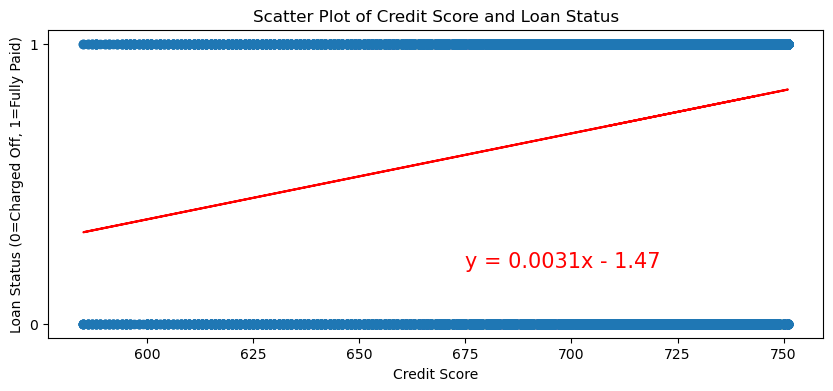

In [227]:
# Create a linear regression between Loan Status and Credit Score
# Extracting Loan Status and Credit Score columns
x_values = df['Credit Score']
y_values = df['Status Value']

# Calculating linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {round(slope, 4)}x - {round(-intercept, 2)}"

# Creating the scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(x_values, y_values)

# Plotting the regression line
plt.plot(x_values, regress_values, "-r")

# Annotating the regression equation
plt.annotate(line_eq, (675, 0.2), fontsize=15, color="red")

# Setting labels and title
plt.xlabel("Credit Score")
plt.ylabel("Loan Status (0=Charged Off, 1=Fully Paid)")
plt.title("Scatter Plot of Credit Score and Loan Status")
plt.ticklabel_format(style='plain', axis='x') 

# Setting y-axis ticks to only display 0 and 1
plt.yticks([0, 1])

# Displaying the plot
plt.show()


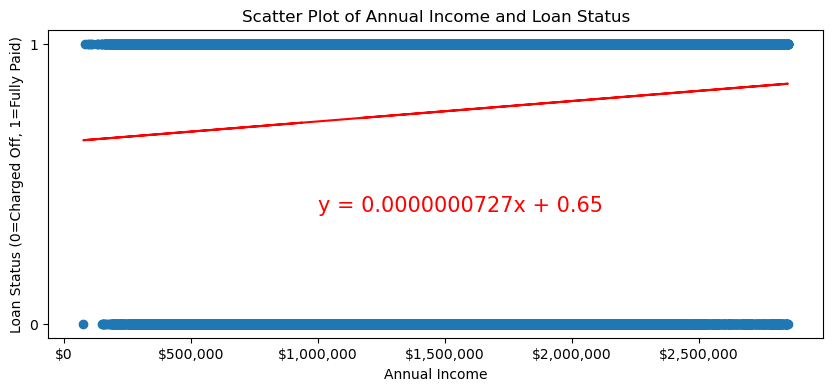

In [228]:
# Create a linear regression between Loan Status and Annual Income
# Extracting Loan Status and Annual Income columns
x_values = df['Annual Income']
y_values = df['Status Value']

# Calculating linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {slope:.10f}x + {round(intercept, 2)}"

# Creating the scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(x_values, y_values)


# Plotting the regression line
plt.plot(x_values, regress_values, "-r")

# Annotating the regression equation and r
plt.annotate(line_eq, (1000000, 0.4), fontsize=15, color="red")

# Setting labels and title
plt.xlabel("Annual Income")
plt.ylabel("Loan Status (0=Charged Off, 1=Fully Paid)")
plt.title("Scatter Plot of Annual Income and Loan Status")
plt.ticklabel_format(style='plain', axis='x') 

# Setting y-axis ticks to only display 0 and 1
plt.yticks([0, 1])

# Formatting x-axis tickmarks as USD
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x))
plt.gca().xaxis.set_major_formatter(formatter)

# Displaying the plot
plt.show()

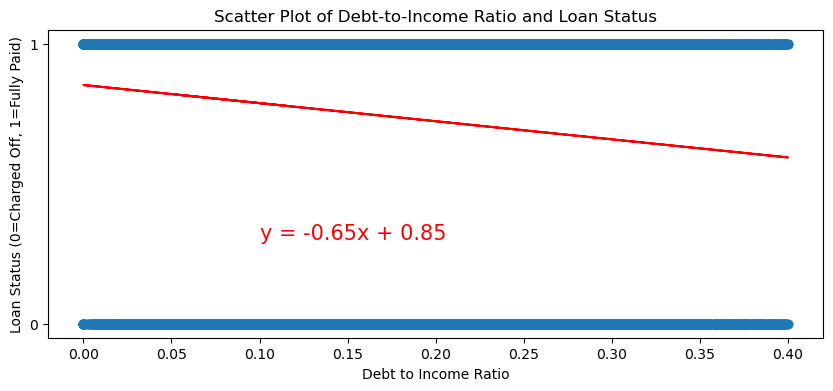

In [229]:
# Create a linear regression between Loan Status and Debt-to-Income Ratio
# Extracting Loan Status and Debt-to-Income Ratio columns
x_values = df["Debt to Income Ratio"]
y_values = df['Status Value']

# Calculating linear regression
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = f"y = {slope:.2f}x + {round(intercept, 2)}"

# Creating the scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(x_values, y_values)

# Plotting the regression line
plt.plot(x_values, regress_values, "-r")

# Annotating the regression equation
plt.annotate(line_eq, (0.1, 0.3), fontsize=15, color="red")

# Setting labels and title
plt.xlabel("Debt to Income Ratio")
plt.ylabel("Loan Status (0=Charged Off, 1=Fully Paid)")
plt.title("Scatter Plot of Debt-to-Income Ratio and Loan Status")
plt.ticklabel_format(style='plain', axis='x') 

# Setting y-axis ticks to only display 0 and 1
plt.yticks([0, 1])

# Displaying the plot
plt.show()


C:\Users\jimmy\AppData\Local\Temp\ipykernel_22912\3603601283.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fullgrouped = df.groupby(['Credit Score Rating','Debt-To-Income Bucket','Loan Status']).size().unstack(fill_value=0)


<Figure size 1600x1000 with 0 Axes>

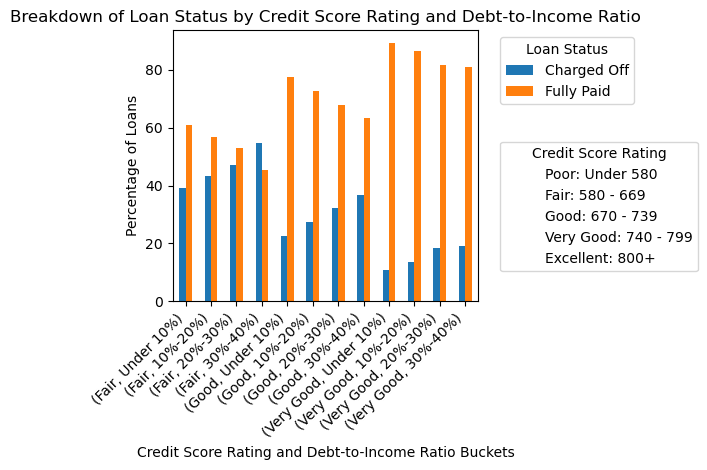

In [230]:
# Grouping the data by 'Credit Score Rating', 'Debt-To-Income Bucket' and Loan Status and counting the occurrences
fullgrouped = df.groupby(['Credit Score Rating','Debt-To-Income Bucket','Loan Status']).size().unstack(fill_value=0)

# Filter out groups with a count of 0
fullgrouped = fullgrouped.loc[fullgrouped.sum(axis=1) > 0]

# Calculating the total count of loans for each purpose
total_loans_by_group = fullgrouped.sum(axis=1)

# Calculating the percentage of loans for each loan status within each purpose
percentage_fullgrouped = fullgrouped.divide(total_loans_by_group, axis=0) * 100

# Plotting the clustered bar graph
plt.figure(figsize=(16, 10))
percentage_fullgrouped.plot(kind='bar', stacked=False)

# Adding labels and title
plt.title('Breakdown of Loan Status by Credit Score Rating and Debt-to-Income Ratio')
plt.xlabel('Credit Score Rating and Debt-to-Income Ratio Buckets')
plt.ylabel('Percentage of Loans')
plt.xticks(rotation=45, ha='right')


# Adding the first legend for Loan Status
legend_loan_status = plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding the second legend for Credit Score Rating
handles = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.0) for _ in range(5)]
credit_labels = ['Poor: Under 580', 'Fair: 580 - 669', 'Good: 670 - 739', 'Very Good: 740 - 799', 'Excellent: 800+']
legend_credit_score = plt.legend(handles, credit_labels, title='Credit Score Rating', bbox_to_anchor=(1.05, .35), loc='center left')

# Adding the second legend using pyplot.gca().add_artist()
plt.gca().add_artist(legend_loan_status)

plt.tight_layout()
plt.show()

# The Clusterer Bar Graph below shows that loans with a rating of Fair and a Debt-to-Income Ratio between 30%-40% tend to be charged off more often than they are paid off